# ALL-IDB classification using AlexNet
### Dataset used:- [ALL-IDB:Acute Lymphoblastic Leukemia Image Database for Image Processing](https://homes.di.unimi.it/scotti/all/)
Follow the instructions provided in the linked website to download the dataset. After downloading, extract the files to the current directory (same folder as your codes). Note that ALL_IDB2 is used in this  tutorial.

In [1]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import time

### Load Data:

In [2]:
Datapath = 'ALL_IDB2/img/'
listing = os.listdir(Datapath)

In [3]:
# ALL_IDB2 dataset has 260 images in total
TrainImages = torch.FloatTensor(200,3,224,224)
TrainLabels = torch.LongTensor(200)
TestImages = torch.FloatTensor(60,3,224,224)
TestLabels = torch.LongTensor(60)

# First 200 images are used for training and the remaining 60 for testing
img_no = 0
for file in listing:
    im=Image.open(Datapath + file)
    im = im.resize((224,224))
    im = np.array(im)   
    if img_no < 200:
        TrainImages[img_no] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
        TrainLabels[img_no] = int(listing[img_no][6:7])
    else:
        TestImages[img_no - 200] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
        TestLabels[img_no - 200] = int(listing[img_no][6:7])
    img_no = img_no + 1

In [4]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([200, 3, 224, 224])
torch.Size([200])
torch.Size([60, 3, 224, 224])
torch.Size([60])


In [5]:
# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 32
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)

In [6]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


### Initialize the network

In [7]:
# AlexNet
net = models.alexnet(pretrained=True)
new_classifier = nn.Sequential(*list(net.classifier.children())[:-1])
new_classifier.add_module('fc',nn.Linear(4096,2))
new_classifier.add_module('softmax',nn.LogSoftmax())
net.classifier = new_classifier
print(net)
if use_gpu:
    net = net.cuda()

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (fc): Linear (4096 -> 2)
    (softmax): LogSoftmax ()
  )
)


### Define loss function and optimizer: 

In [8]:
criterion = nn.NLLLoss() # Negative Log-Likelihood
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9) # Stochastic gradient descent

## Train the network

At Iteration: 1 /20  ;  Training Loss: 0.026363 ; Testing Acc: 50.000 ; Time consumed: 0m 1s 
At Iteration: 2 /20  ;  Training Loss: 0.024245 ; Testing Acc: 65.000 ; Time consumed: 0m 0s 
At Iteration: 3 /20  ;  Training Loss: 0.020147 ; Testing Acc: 80.000 ; Time consumed: 0m 0s 
At Iteration: 4 /20  ;  Training Loss: 0.018053 ; Testing Acc: 91.667 ; Time consumed: 0m 0s 
At Iteration: 5 /20  ;  Training Loss: 0.014854 ; Testing Acc: 73.333 ; Time consumed: 0m 0s 
At Iteration: 6 /20  ;  Training Loss: 0.012897 ; Testing Acc: 91.667 ; Time consumed: 0m 0s 
At Iteration: 7 /20  ;  Training Loss: 0.011462 ; Testing Acc: 80.000 ; Time consumed: 0m 0s 
At Iteration: 8 /20  ;  Training Loss: 0.011243 ; Testing Acc: 93.333 ; Time consumed: 0m 0s 
At Iteration: 9 /20  ;  Training Loss: 0.009161 ; Testing Acc: 91.667 ; Time consumed: 0m 0s 
At Iteration: 10 /20  ;  Training Loss: 0.010263 ; Testing Acc: 88.333 ; Time consumed: 0m 0s 
At Iteration: 11 /20  ;  Training Loss: 0.010276 ; Testing 

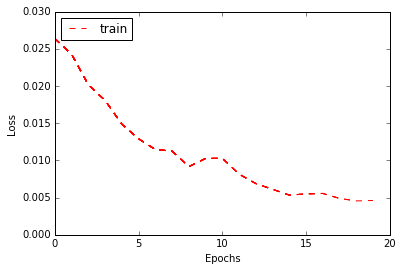

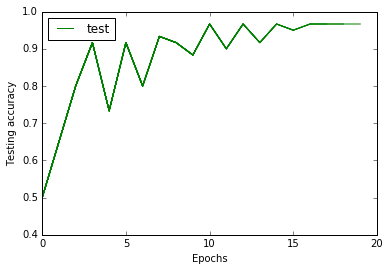

In [9]:
iterations = 20
trainLoss = []
testAcc = []

start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0    
    net.train(True) # For training
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.float().cuda()), \
                Variable(labels.long().cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labelslong()) 
        inputs = inputs/255.0
        # Initialize gradients to zero
        optimizer.zero_grad()
        # Feed-forward input data through the network
        outputs = net(inputs)
        # Compute loss/error
        loss = criterion(outputs, labels)        
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data[0]    
    avgTrainLoss = runningLoss/200
    trainLoss.append(avgTrainLoss)
    # Evaluating performance on test set for each epoch
    net.train(False) # For testing
    inputs = TestImages/255
    if use_gpu:
        inputs = Variable(inputs.cuda())
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()
    else:
        inputs = Variable(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    avgTestAcc = correct/60.0
    testAcc.append(avgTestAcc)
        
    # Plotting Loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')    
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Testing accuracy')    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc*100,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))